In [167]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nsepython as nse
import datetime 
from sklearn.preprocessing import StandardScaler


In [168]:
start_date = datetime.date(year=2015,month=1,day=1)
start_date = start_date.strftime(format="%Y-%m-%d")
end_date = datetime.date.today()
end_date = end_date.strftime(format="%Y-%m-%d")

In [169]:
# Index names 'NIFTY 50','NIFTY BANK'
df = nse.index_history(symbol="NIFTY 50",start_date=start_date,end_date=end_date)
# Column selection and renaming
df = df[['HistoricalDate','OPEN','HIGH','LOW','CLOSE']]
df.columns = ['Date','Open','High','Low','Close']
def split_date(i):
    return i.split()[0],i.split()[1],i.split()[2]
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
def weekno(i):
    return i.strftime("%W")
df['Week'] = df['Date'].apply(weekno)
# df['Day'] = df['Date'].apply(split_date[0])
# df['Month'] = df['Date'].apply(split_date[1])
# df['Year'] = df['Date'].apply(split_date[2])
df  = df.set_index(keys='Date')
for i in df:
    df[i] = df[i].astype(float)
df.head()

,Open,High,Low,Close,Day,Month,Week
Date,,,,,,,
2025-04-03,23150.30,23306.50,23145.80,23250.10,3.0,4.0,13.0
2025-04-02,23192.60,23350.00,23158.45,23332.35,2.0,4.0,13.0
2025-04-01,23341.10,23565.15,23136.40,23165.70,1.0,4.0,13.0
2025-03-28,23600.40,23649.20,23450.20,23519.35,28.0,3.0,12.0
2025-03-27,23433.95,23646.45,23412.20,23591.95,27.0,3.0,12.0


In [170]:
# Addressing stationarity
for i in ['Open','High','Low','Close']:
    df[f'{i}'] = round(((df[f'{i}'].diff(-1))/(df[f'{i}'].shift(-1)))*100,2)
df['Nxt_Open'] = df['Open'].shift(1)
df['Nxt_Close'] = df['Close'].shift(1)
def quarter(i):
    return np.ceil(i/3)
df['Quarter'] = df['Month'].apply(quarter)
df = df.dropna()
df = df[::-1]
df.tail()

,Open,High,Low,Close,Day,Month,Week,Nxt_Open,Nxt_Close,Quarter
Date,,,,,,,,,,
2025-03-26,-0.21,-0.56,-0.63,-0.77,26.0,3.0,12.0,-1.13,0.45,1.0
2025-03-27,-1.13,-0.38,-0.17,0.45,27.0,3.0,12.0,0.71,-0.31,1.0
2025-03-28,0.71,0.01,0.16,-0.31,28.0,3.0,12.0,-1.10,-1.50,1.0
2025-04-01,-1.10,-0.36,-1.34,-1.50,1.0,4.0,13.0,-0.64,0.72,2.0
2025-04-02,-0.64,-0.91,0.10,0.72,2.0,4.0,13.0,-0.18,-0.35,2.0


In [171]:
# Train test split
test_df = df.iloc[-540:]
train_df = df.iloc[:2000]
X_train,y_train = train_df.drop('Nxt_Close',axis=1),train_df['Nxt_Close']
X_test,y_test = test_df.drop('Nxt_Close',axis=1),test_df['Nxt_Close']

In [172]:
# Feature creation 1
def feature_creation1(df):
    for i in ['Open','High','Low','Close']:
        for j in ['Day','Week','Month','Quarter']:
            data = df.groupby(by=j)[i].std()
            data = dict(data)
            df[f'{i}_{j}_Std'] = df[j].map(data)
    for k in df:
        df[k] = df[k].apply(lambda i: round(i,2))
    df = df.dropna()
    return df

X_train = feature_creation1(X_train)
X_test = feature_creation1(X_test)

# matching y indices
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]





In [173]:
# Correlation analysis 
pd.concat([X_train,y_train],axis=1).corr()
# Corr analysis remains inconclusive

,Open,High,Low,Close,Day,Month,Week,Nxt_Open,Quarter,Open_Day_Std,...,High_Quarter_Std,Low_Day_Std,Low_Week_Std,Low_Month_Std,Low_Quarter_Std,Close_Day_Std,Close_Week_Std,Close_Month_Std,Close_Quarter_Std,Nxt_Close
Open,1.000000,0.721610,0.741147,0.323309,0.000808,0.016043,0.016011,-0.061950,0.026475,-0.024090,...,-0.026511,-0.021235,-0.050105,-0.038093,-0.032005,-0.011968,-0.032556,-0.030202,-0.029682,-0.055598
High,0.721610,1.000000,0.700632,0.728921,0.012251,0.019336,0.020035,0.314092,0.033301,-0.031255,...,-0.033507,-0.036409,-0.071323,-0.050512,-0.041077,-0.021057,-0.049713,-0.039116,-0.037781,-0.033261
Low,0.741147,0.700632,1.000000,0.688291,-0.003169,0.023052,0.022579,0.319691,0.031457,-0.016721,...,-0.030970,-0.043974,-0.062272,-0.029456,-0.037306,-0.014084,-0.037262,-0.023435,-0.034693,-0.024551
Close,0.323309,0.728921,0.688291,1.000000,0.007109,0.019226,0.019422,0.622743,0.028819,-0.008464,...,-0.028824,-0.032111,-0.061057,-0.032947,-0.035218,-0.007250,-0.039418,-0.025057,-0.032465,-0.020957
Day,0.000808,0.012251,-0.003169,0.007109,1.000000,0.016324,0.098426,0.016054,0.019574,0.171391,...,-0.020347,0.031312,0.027055,-0.004920,-0.027532,0.103831,0.033868,0.004100,-0.024046,0.030377
Month,0.016043,0.019336,0.023052,0.019226,0.016324,1.000000,0.996365,0.019022,0.971830,0.009631,...,-0.955029,0.000324,-0.300430,-0.344327,-0.854201,-0.009315,-0.414837,-0.494238,-0.936017,0.020982
Week,0.016011,0.020035,0.022579,0.019422,0.098426,0.996365,1.000000,0.020328,0.968694,0.023995,...,-0.951866,0.003241,-0.297921,-0.344531,-0.850890,-0.000654,-0.411733,-0.493514,-0.932708,0.023710
Nxt_Open,-0.061950,0.314092,0.319691,0.622743,0.016054,0.019022,0.020328,1.000000,0.027619,0.004239,...,-0.027965,-0.007560,-0.053872,-0.034065,-0.034659,0.014418,-0.029718,-0.027665,-0.031684,0.322977
Quarter,0.026475,0.033301,0.031457,0.028819,0.019574,0.971830,0.968694,0.027619,1.000000,0.011099,...,-0.983534,0.001789,-0.396628,-0.473074,-0.876846,-0.007928,-0.482178,-0.576179,-0.962578,0.029242
Open_Day_Std,-0.024090,-0.031255,-0.016721,-0.008464,0.171391,0.009631,0.023995,0.004239,0.011099,1.000000,...,-0.010522,0.756341,0.038192,0.003290,-0.012137,0.242133,0.012649,0.004260,-0.011586,0.008217


In [174]:
# Keep only on of following active

# # For range bound                     ........select either this 
# def classification(i):
#     if (i<=0.5) & (i>=-0.5):
#         return 0
#     else:
#         return 1

# For up and down prediction            ................or this     
def classification(i):                  
    if i<0:
        return 0
    else:
        return 1

y_train = y_train.apply(classification)
y_test = y_test.apply(classification)

In [175]:
# class weight
t = y_train.value_counts(normalize=True)
cls = list(t.index)
val = list(t.values)
class_weight = {cls[0]:float(val[1]),cls[1]:float(val[0])}
class_weight

{1: 0.4607303651825913, 0: 0.5392696348174087}

In [176]:
# Scaling 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

R2 scores :
Train data :  0.6408204102051025
Test data :  0.6388888888888888

classification_report
              precision    recall  f1-score   support

           0       0.64      0.41      0.50       238
           1       0.64      0.82      0.72       302

    accuracy                           0.64       540
   macro avg       0.64      0.61      0.61       540
weighted avg       0.64      0.64      0.62       540




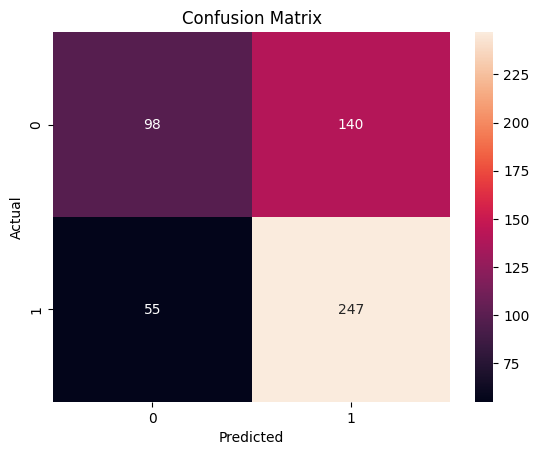

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,\
roc_curve,auc,precision_recall_curve

clf = LogisticRegression(random_state=11,max_iter=1000,class_weight=class_weight) #class_weight=class_weight,
clf.fit(X_train,y_train)

print('R2 scores :')
print("Train data : ",clf.score(X_train,y_train))
print("Test data : ",clf.score(X_test,y_test))
print()

y_pred = clf.predict(X_test)
y_pred = pd.Series(y_pred,index=y_test.index)

cr = classification_report(y_test,y_pred)
print("classification_report")
print(cr)
print()

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

New threshold is :  0.3165869440187093

classification_report
              precision    recall  f1-score   support

           0       0.80      0.07      0.12       238
           1       0.57      0.99      0.73       302

    accuracy                           0.58       540
   macro avg       0.69      0.53      0.42       540
weighted avg       0.67      0.58      0.46       540




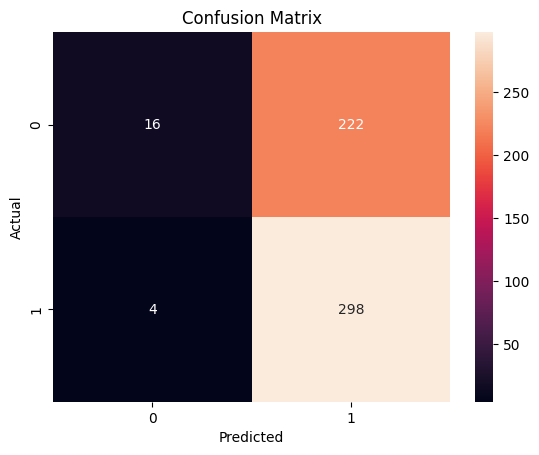

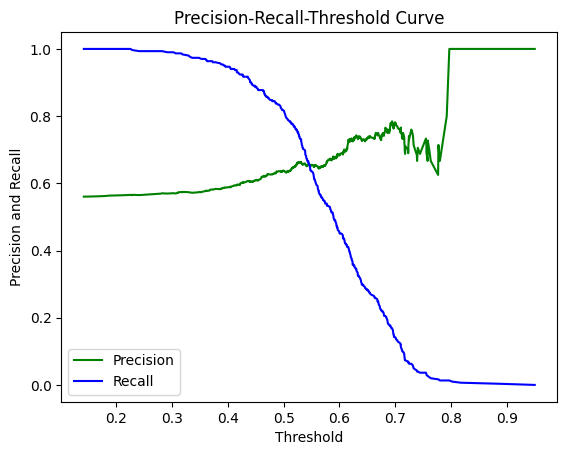

In [178]:
# calculate f1 scores for all threshold
y_score = clf.predict_proba(X_test)
pr,rc,th = precision_recall_curve(y_test,y_score[:,1])
f1 = [round(float((2*i*j)/(i+j)),2) for i,j in zip(pr,rc)]

# find index of f1 and max f1 score and threshold corresponding to it
f1_max_index = np.argmax(f1)
f1_max_score = f1[f1_max_index]

# threshold corresponding to max f1 score for class1
threshold = th[f1_max_index]
print("New threshold is : ",threshold)
print()

# repredict y_pred using threshold
y_prob = clf.predict_proba(X_test)
y_pred_new = [1 if i >= threshold else 0 for i in y_prob[:,1]]

# New performance matrix
cr = classification_report(y_test,y_pred_new)
print("classification_report")
print(cr)
print()

# New performance metrics
cm = confusion_matrix(y_test,y_pred_new)
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# threshold - precsion - recall curve
sns.lineplot(x=th,y=pr[1:],color='green',label='Precision')
sns.lineplot(x=th,y=rc[1:],color='blue',label='Recall')
plt.title('Precision-Recall-Threshold Curve')
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall')
plt.show()